In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# extracting data and doing the fit on velocity

In [2]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    file_exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
file_data = read_edf(datafile, 'TRIALID')

In [3]:
block = 0
trial = 13

from ANEMO import ANEMO
arg = ANEMO.arg(file_data, file_exp, trial, block)

N_trials = arg.N_trials

time = arg.trackertime
t_0 = arg.trackertime_0

trial_data = trial + N_trials*block

data_x = arg.data_x -(arg.data_x[arg.StimulusOf-t_0])
#data_x = arg.data_x-(arg.screen_width_px/2)

start = arg.TargetOn
start1 = arg.TargetOn-t_0

In [4]:
def deco(axs) :
    axs.axvspan(arg.StimulusOn-start, arg.StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(arg.StimulusOf-start, arg.TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(arg.TargetOn-start, arg.TargetOff-start, color='k', alpha=0.15)
    for s in range(len(arg.saccades)) :
        axs.axvspan(arg.saccades[s][0]-start, arg.saccades[s][1]-start, color='k', alpha=0.2)

In [5]:
def saccade(x, x_0, tau, x1, x2, T0, t1, t2, tr):
    
    time = x-T0
    T1 = t1
    T2 = t1+t2
    TR = T2+tr
    
    rho = (tau/T1) * np.log((1+np.exp(T1/tau))/2)
    rhoT = int(np.round(T1*rho))
    
    r = (tau/T2) * np.log((np.exp(T1/tau) + np.exp(T2/tau)) /2)
    rT = int(np.round(T2*r))
    Umax1 = (1/tau) * x1 / ((2*rho-1)*T1 - tau*(2-np.exp(-(rho*T1)/tau) - np.exp((1-rho)*T1/tau)))
    Umax2 = (1/tau) * (x2-x1) / ((2*r-1)*T2-T1)

    xx = []
    
    for t in time :
        if t < 0 :
            xx.append(x_0)
        elif t < rhoT :
            xx.append((x_0 +      Umax1*tau * ((t)    - tau*(1-np.exp(-t/tau)))))
        elif t < T1 :
            xx.append(x_0 + (x1 + Umax1*tau * ((T1-t) + tau*(1-np.exp((T1-t)/tau)))))
        elif t < rT :
            xx.append(x_0 + (x1 + Umax2*tau * ((t-T1) - tau*(1-np.exp(-(t-T1)/tau)))))
        elif t < TR :
            xx.append(x_0 + (x2 + Umax2*tau * ((T2-t) + tau*(1-np.exp((T2-t)/tau)))))
        else :
            xx.append(xx[-1])
    
    return xx

In [6]:
def position(x, bino, start_anti, v_anti, latence, tau, maxi, avant, apres):
    
    #gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
    ms = 1000
    v_anti = (v_anti/1000) #/ms # pour passer de sec à ms
    maxi = maxi /ms
    
    speed = ANEMO.fct_exponentiel(x, bino, start_anti, v_anti, latence, tau, maxi)
    pos = np.cumsum(speed)

    for sacc in arg.saccades :
        if sacc[0]-t_0 > int(latence) :
            # [starttime, endtime, duration, startx, starty, endx, endy]
            pos[int(sacc[0]-t_0)-avant:int(sacc[1]-t_0)+apres] = pos[int(sacc[0]-t_0)-avant-1]  #np.nan 
            pos[int(sacc[1]-t_0)+apres:] += ((data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])/ arg.px_per_deg) - np.mean(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]

 
    return pos

# doing the fit

In [7]:
def Fit_position(velocity_x, trackertime, bino, param_fit=None, TargetOn=arg.TargetOn, avant=0, apres=15,
                 StimulusOf=arg.StimulusOf, saccades=arg.saccades, sup=False, time_sup=-280, step=2) :

    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,1.,40], 'v_anti':[0.,-100.,100.],
                   'latence':[TargetOn-t_0+100, TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]} #'v_anti':[0.,-40.,40.]

    if param_fit['latence'][2]=='STOP' :
        stop_latence = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latence.append((saccades[s][0]-t_0))
        if stop_latence==[] :
            stop_latence.append(len(trackertime))
        stop = stop_latence[0]
    else :
        stop = param_fit['latence'][2]


    if sup==True :
        velocity_x = velocity_x[:time_sup]
        trackertime = trackertime[:time_sup]
    
    model = Model(position)

    params = Parameters()

    if step == 1 :
        vary = True
    elif step == 2 :
        vary = False

    params.add('bino', value=bino, vary=False)
    params.add('avant', value=avant, vary=False)
    params.add('apres', value=apres, vary=False)
    
    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latence', value=param_fit['latence'][0], min=param_fit['latence'][1], max=stop)
    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vary)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vary)
    params.add('v_anti', value=param_fit['v_anti'][0], min=param_fit['v_anti'][1], max=param_fit['v_anti'][2], vary=vary)

    if step == 1 :
        result_deg = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')

    elif step == 2 :
        out = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['v_anti'].set(vary=True)

        result_deg = model.fit(velocity_x, out.params, x=np.arange(len(trackertime)), method='nelder', nan_policy='omit')
                                
    return result_deg

In [8]:
def Fit_saccade(position_x) :

    from lmfit import  Model, Parameters

    model = Model(saccade)

    params = Parameters()
    params.add('x_0', value=position_x[0], vary=False)
    params.add('tau', value=13, min=1, max=40)
    params.add('T0', value=2, min=0, max=len(position_x))
    params.add('t1', value=15, min=10, max=20)#len(position_x))
    params.add('t2', value=20, min=0, max=len(position_x)/2)
    params.add('tr', value=0, min=0, max=10)
    params.add('x1', value=-2, min=-5, max=5)
    params.add('x2', value=-3, min=-5, max=5)

    result_deg = model.fit(position_x, params, x=np.arange(len(position_x)), nan_policy='omit')

    return result_deg

# Residu!

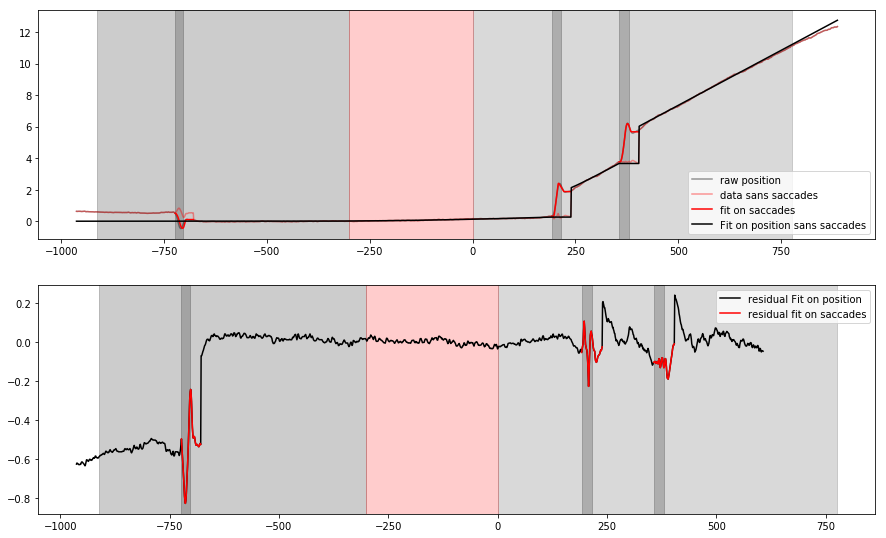

In [9]:
debut, fin = 0, 25

fig_width= 15
fig, axs = plt.subplots(2, 1, figsize=(fig_width, 2*(fig_width/2)/1.6180))
deco(axs[0])
deco(axs[1])


data_1 = np.copy(data_x)/arg.px_per_deg
data_2 = np.copy(data_1)

data1_sacc = np.copy(data_x)*np.nan
for s in range(len(arg.saccades)):
    data_sacc  = data_1[arg.saccades[s][0]-t_0-debut:arg.saccades[s][1]-t_0+fin]
    f = Fit_saccade(data_sacc)
    data1_sacc[arg.saccades[s][0]-t_0-debut:arg.saccades[s][1]-t_0+fin] = f.best_fit
    data_2[arg.saccades[s][0]-t_0-debut:arg.saccades[s][1]-t_0+fin] = f.residual+f.values['x_0']
    

c = Fit_position(data_2,time, arg.bino,step=2, sup=True, time_sup=-280, avant=debut, apres=fin)
d = position(np.arange(len(time)), arg.bino, c.values['start_anti'], c.values['v_anti'],
             c.values['latence'], c.values['tau'], c.values['maxi'],avant=debut, apres=fin)

axs[0].plot(time-start, data_1, color='k', alpha=0.4, label='raw position')
axs[0].plot(time-start, data_2 , 'r', alpha=0.4, label='data sans saccades')
axs[0].plot(time-start, data1_sacc , 'r', label='fit on saccades')
axs[0].plot(time-start, d , 'k', label='Fit on position sans saccades')
axs[0].legend();

data1_residu = np.copy(data_x)*np.nan
for s in range(len(arg.saccades)):
    data_sacc  = data_1[arg.saccades[s][0]-t_0-debut:arg.saccades[s][1]-t_0+fin]
    f = Fit_saccade(data_sacc)
    data1_residu[arg.saccades[s][0]-t_0-debut:arg.saccades[s][1]-t_0+fin] = -f.residual+c.residual[arg.saccades[s][0]-t_0-debut]
    

axs[1].plot(np.arange(len(c.residual))-start1, c.residual, 'k', label='residual Fit on position')
axs[1].plot(time-start, data1_residu , 'r', label='residual fit on saccades')
axs[1].legend();

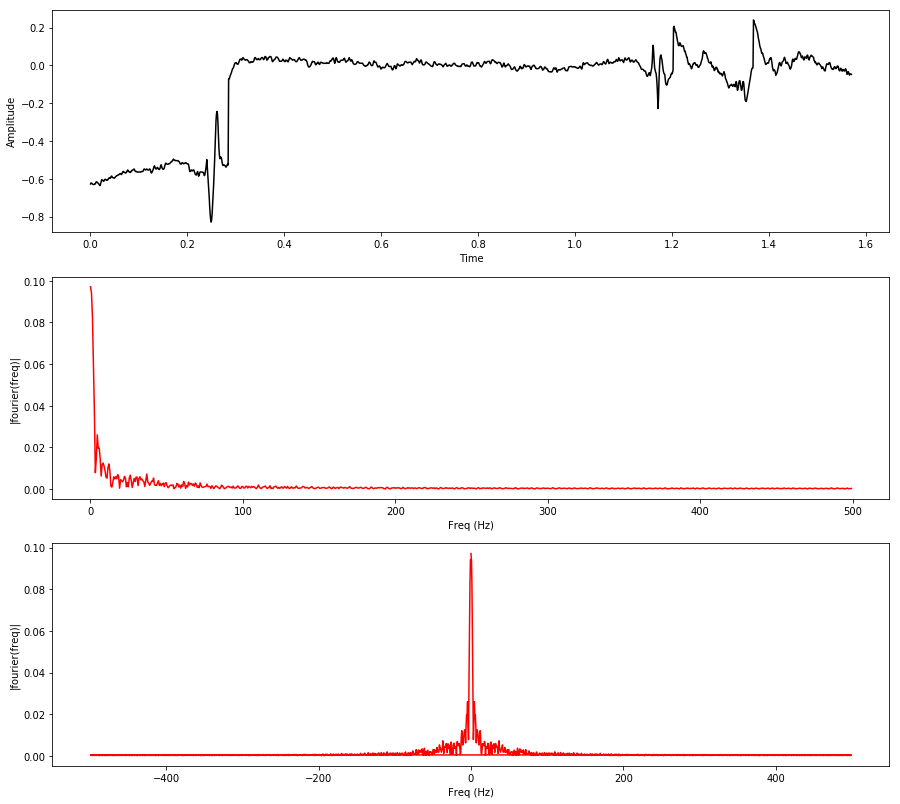

In [10]:
# calcul de la transformee de Fourier et des frequences
Fs = 1000.0  # taux d'échantillonnage
dt = 1.0/Fs  # intervalle d'échantillonnage
t = np.arange(0,len(c.residual)/1000,dt) # vecteur de temps

n = len(c.residual) # longueur du signal
k = np.arange(n)
T = n/Fs
frq = k/T # gamme de fréquence de deux côtés
frq = frq[range(int(n/2))] # une gamme de fréquence latérale
freq = np.fft.fftfreq(n, d=dt)


fourier = np.fft.fft(c.residual)/n # fft informatique et normalisation

fig, ax = plt.subplots(3, 1, figsize=(fig_width, 3*(fig_width/2)/1.6180))
ax[0].plot(t, c.residual, 'k')
ax[1].plot(frq, abs(fourier[range(int(n/2))]),'r')
ax[2].plot(freq, abs(fourier),'r')


ax[0].set_xlabel('Time'); ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('Freq (Hz)'); ax[1].set_ylabel('|fourier(freq)|')
ax[2].set_xlabel('Freq (Hz)'); ax[2].set_ylabel('|fourier(freq)|');